In [1]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

#### Load image

In [ ]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img
images = images.map(load_image)

images.as_numpy_iterator().next()

#### View loaded image using Matplotlib

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

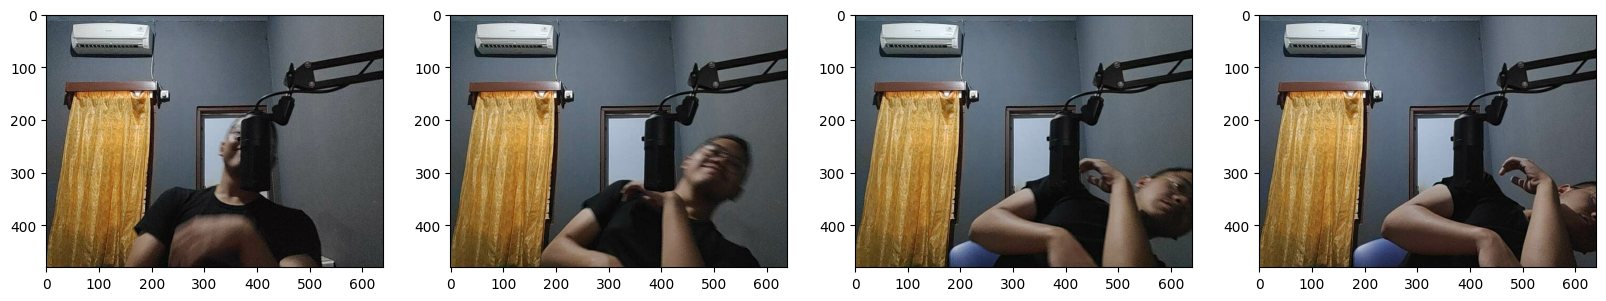

In [14]:
fix, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, image in enumerate(plot_images):
    ax[i].imshow(image)
plt.show()

### Splitting Data

Split data manually, following code is for moving the labels after images moved to data/[train, tes, val] folder

In [4]:
import os

In [18]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

### Augmenting Single Data

In [5]:
import albumentations as alb

In [6]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [33]:
# Load one image and annotation
img = cv2.imread(os.path.join('data','train','images','eb3a0399-6653-11ee-a861-d05099a71dfe.jpg'))
with open(os.path.join('data','train','labels', 'eb3a0399-6653-11ee-a861-d05099a71dfe.json'), 'r') as f:
    label = json.load(f)


In [41]:
# label

In [37]:
# Extract Coordinate and rescaling
x_min = label['shapes'][0]['points'][0][0]
y_min = label['shapes'][0]['points'][0][1]
x_max = label['shapes'][0]['points'][1][0]
y_max = label['shapes'][0]['points'][1][1]
coordinates = [x_min, y_min, x_max, y_max]

# coordinates
# [251.88976377952753, 124.64566929133858, 377.0866141732283, 275.8267716535433]
# coordinates variable would form a box with 4 points (x,y) -> (251, 124), (251, 275), (377, 124), (377, 275)

In [39]:
# Rescale with the resolution of camera capture
coordinates = (np.divide(coordinates, [640, 480, 640, 480]))

In [42]:
# Augment
augmented = augmentor(image=img, bboxes=[coordinates], class_labels=['visible_face'])

In [47]:
# Before after augmentaion
print(coordinates)
print(augmented['bboxes'])

[0.39357776 0.25967848 0.58919783 0.57463911]
[(0.4109186351706037, 0.2103237095363079, 0.6891338582677167, 0.5462817147856518)]


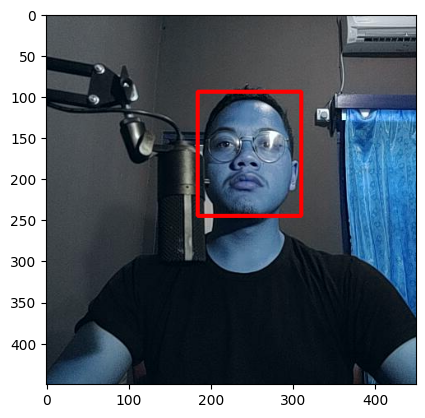

In [53]:
# Visualize the augmentation
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Run Augmentation Pipeline on train dataset

In [9]:
for folder in ['train', 'val', 'test']:
    for image in os.listdir(os.path.join('data', folder, 'images')):
        filepath = os.path.join('data', folder, 'images', image)
        img = cv2.imread(filepath)

        coordinates = [0,0,0.00001,0.00001]
        labelpath = os.path.join('data', folder, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(labelpath):
            with open(labelpath, 'r') as f:
                label = json.load(f)
            coordinates[0] = label['shapes'][0]['points'][0][0]
            coordinates[1] = label['shapes'][0]['points'][0][1]
            coordinates[2] = label['shapes'][0]['points'][1][0]
            coordinates[3] = label['shapes'][0]['points'][1][1]
            coordinates = list(np.divide(coordinates, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coordinates], class_labels=['visible_face'])
                cv2.imwrite(os.path.join('aug_data', folder, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(labelpath):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', folder, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

y_max is less than or equal to y_min for bbox [0.389886811023622, 0.21702755905511814, 0.5474068135636271, 2.960594732333751e-17, 'visible_face'].
y_max is less than or equal to y_min for bbox [0.42802657480314954, 0.19406167979002623, 0.5845805349698934, 0.0, 'visible_face'].
y_max is less than or equal to y_min for bbox [0.6310285433070866, 0.19406167979002623, 0.7971938566272966, 0.0, 'visible_face'].
y_max is less than or equal to y_min for bbox [0.31729822834645666, 0.30725065616797903, 0.491352456441615, 0.0, 'visible_face'].
y_max is less than or equal to y_min for bbox [0.26316437007874016, 0.2957677165354331, 0.43858782440141403, 0.0, 'visible_face'].
y_max is less than or equal to y_min for bbox [0.11675688976377949, 0.27608267716535434, 0.31171000828843765, 0.0, 'visible_face'].
y_max is less than or equal to y_min for bbox [0.6802411417322834, 0.1825787401574803, 0.8452354540467277, 0.0, 'visible_face'].
x_max is less than or equal to x_min for bbox [0.26070374015748027, 0.

### Load Augmented File

In [12]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [13]:
train_images.as_numpy_iterator().next()

array([[[0.43792892, 0.38694853, 0.4143995 ],
        [0.4148897 , 0.3639093 , 0.39136028],
        [0.42205882, 0.37107843, 0.3985294 ],
        ...,
        [0.37916666, 0.3711397 , 0.41856617],
        [0.36868873, 0.35251224, 0.39417893],
        [0.34485295, 0.32867646, 0.37034315]],

       [[0.3935662 , 0.34258577, 0.37003675],
        [0.41525736, 0.36427698, 0.39172795],
        [0.39797795, 0.34699756, 0.37444854],
        ...,
        [0.9757353 , 0.9468137 , 0.97818625],
        [0.9795956 , 0.9363358 , 0.9603554 ],
        [0.94264704, 0.8990196 , 0.91862744]],

       [[0.40067402, 0.34969363, 0.3771446 ],
        [0.44552696, 0.39454657, 0.42199755],
        [0.4139706 , 0.3629902 , 0.39044118],
        ...,
        [0.71096814, 0.6742647 , 0.6956495 ],
        [0.9348039 , 0.877451  , 0.8905637 ],
        [0.9363971 , 0.8887868 , 0.9017157 ]],

       ...,

       [[0.2471201 , 0.18829657, 0.20790441],
        [0.23272058, 0.17389706, 0.1935049 ],
        [0.23069853, 0

### Prepare Labels

In [14]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [21]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [33]:
test_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.795 , 0.2357, 1.    , 0.5454], dtype=float16))

In [34]:
train_labels

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None))>

### Combine Label and Images

In [37]:
len(train_images),len(train_labels), len(test_images),len(test_labels), len(test_images),len(test_labels)

(3180, 3180, 660, 660, 660, 660)

#### Finalize Image and Labels

In [40]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

In [41]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [42]:
train.as_numpy_iterator().next()

(array([[[[0.39019608, 0.43425244, 0.44025734],
          [0.3836397 , 0.42022058, 0.4365809 ],
          [0.38878676, 0.41917893, 0.4461397 ],
          ...,
          [0.3411152 , 0.36072305, 0.37248775],
          [0.33566177, 0.3552696 , 0.36703432],
          [0.35741422, 0.37702206, 0.39031863]],
 
         [[0.36764705, 0.40686274, 0.41256127],
          [0.38302696, 0.42132354, 0.43204656],
          [0.3891544 , 0.42444852, 0.4528799 ],
          ...,
          [0.33903188, 0.35863972, 0.37040442],
          [0.3518995 , 0.37150735, 0.38327205],
          [0.36139706, 0.3810049 , 0.3927696 ]],
 
         [[0.2305147 , 0.25796568, 0.2814951 ],
          [0.24246323, 0.27732843, 0.3134804 ],
          [0.2867647 , 0.3259804 , 0.36519608],
          ...,
          [0.3319853 , 0.35159314, 0.36335784],
          [0.33351716, 0.353125  , 0.3648897 ],
          [0.33259803, 0.35220587, 0.36397058]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

### View Image Sample

In [46]:
data_samples = test.as_numpy_iterator()
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


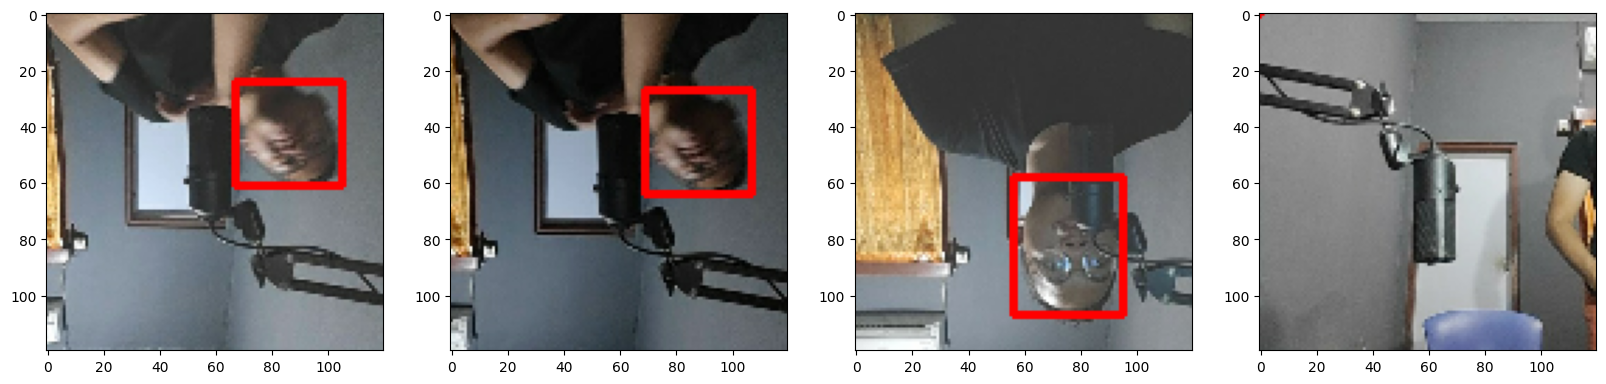

In [49]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coordinate = res[1][1][idx]

    cv2.rectangle(sample_image,
                tuple(np.multiply(sample_coordinate[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coordinate[2:], [120,120]).astype(int)), (255,0,0), 2)
    ax[idx].imshow(sample_image)

